# Table of Contents
 <p><div class="lev1"><a href="#Data-Dashboard-library/plugin-concept"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Dashboard library/plugin concept</a></div><div class="lev2"><a href="#Propose"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Propose</a></div><div class="lev3"><a href="#Data-information"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Data information</a></div><div class="lev3"><a href="#Data-cleaning"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev3"><a href="#Data-visualization"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Data visualization</a></div><div class="lev1"><a href="#Source"><span class="toc-item-num">2&nbsp;&nbsp;</span>Source</a></div><div class="lev2"><a href="#Initializing"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initializing</a></div><div class="lev2"><a href="#Summarized-data-functions"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Summarized data functions</a></div><div class="lev2"><a href="#DataAnalysisWidget"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DataAnalysisWidget</a></div><div class="lev1"><a href="#Test"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test</a></div><div class="lev2"><a href="#Get-the-data"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Get the data</a></div><div class="lev2"><a href="#Prepare-the-data"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prepare the data</a></div><div class="lev2"><a href="#Interactive-Data-Analysis"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Interactive Data Analysis</a></div><div class="lev1"><a href="#References"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div>

# Data Dashboard library/plugin concept

## Propose

The propose of this library/plugin is to allow the data analysis process more 
easy and automatic.

The library will join some methods to help the data manipulation, data cleaning 
and data visualization.

### Data information

When a dataframe were selected, the library will show some information about the
dataframe, such as:

* total of attributes;
* total of instances;
* type of each attributes;
* total of NaN values for each attribute;

### Data cleaning

To improve the user's experience, the user should cleaning and prepare the data 
before call graphical functions.

### Data visualization

Data visualization is divided into 2 parts: the first one is the summary about
the data, as described at section 1.1.1; the second one are graphical summaries.

The graphical summaries is composed by 2 sections: the first one is a interactive 
parameterized chart when the user can chose its fields; the second one is a 
composed chart when the user can see all fields combined with a specific field.


# Source

## Initializing

**Requirements:**

* IPython
* ipywidgets;
* matplotlib;
* numpy;
* pandas;
* textwrap
* traceback

In [1]:
from IPython.display import display, HTML
from ipywidgets import widgets, interactive, IntSlider
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import qgrid  # https://github.com/quantopian/qgrid
# import statsmodels.api as sm
import textwrap
import traceback

plt.style.use('ggplot')
%matplotlib notebook

## Summarized data functions

In [2]:
def summary(data: pd.DataFrame):
    """
    
    """   
    # types
    df = pd.DataFrame(data.dtypes).rename(columns={0: 'Types'})
    
    # set
    df = pd.merge(
        df, pd.DataFrame(
            data.apply(lambda se : str(sorted(set(se.dropna())))[:1000])
        ).rename(columns={0: 'Set Values'}),
        left_index=True, right_index=True
    )
    
    # total observations
    df = pd.merge(
        df, pd.DataFrame(
            data.count()
        ).rename(columns={0: '# Observations'}),
        left_index=True, right_index=True
    )
    
    # total of nan
    df = pd.merge(
        df, pd.DataFrame(data.isnull().sum()).rename(columns={0: '# NaN'}),
        left_index=True, right_index=True
    )
    return df


def process_query(
    data: pd.DataFrame, 
    field_reference: str, 
    fields_comparison: [str],
    bins: int
) -> pd.DataFrame:
    """

    """
    labels_reference = []
    labels = []

    if not (fields_comparison and field_reference):
        return data

    _data = data[list(fields_comparison)+[field_reference]].copy()
    for f in list(fields_comparison)+[field_reference]:
        try:
            if isinstance(data[f].dtype.type(), np.number):
                _data[f], _ = pd.cut(data[f].copy(), bins=bins, retbins=True)
        except:
            pass
            
    return pd.crosstab(
        [_data[f] for f in fields_comparison], 
        _data[field_reference]
    )

## DataAnalysisWidget

In [3]:
class DataAnalysisWidget:
    def __init__(
        self, data: pd.DataFrame,
        field_reference: str, fields_comparison: [str]
    ):
        self.w_bins = IntSlider(min=2, max=10, value=2)
        self.data = data
        self.data_info = summary(self.data)
        self._data = None
        self.field_reference = field_reference
        self.fields_comparison = fields_comparison

        self.w_fields_comparison = widgets.SelectMultiple(
            description='Xs:',
            options=[i for i in self.data.keys()],
            selected_labels=fields_comparison
        )

        self.w_field_reference = widgets.Dropdown(
            description='Y:',
            options=[i for i in self.data.keys()],
            selected_label=field_reference
        )
        
        
    def make_chart(self):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()

        """
        # display chart
        ax = plt.figure().gca()

        try:
            self._data.plot.bar(ax=ax, stacked=True)

            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
        except:
            t = '<br/>'.join(textwrap.wrap(traceback.format_exc(), 80))
            display(t)
        return ax
    
    def summary(self):
        display(self.data_info)
        
    def make_datatable(self):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()

        """

        #if fields and ref_field:
        try:
            display(self._data)
        except:
            t = '<br/>'.join(textwrap.wrap(traceback.format_exc(), 80))
            display(t)
        return
    
    def interactive_info(
        self, field_reference: str, fields_comparison: [str], bins
    ):
        self._data = process_query(
            data=self.data, 
            field_reference=field_reference, 
            fields_comparison=fields_comparison,
            bins=bins
        )

        self.make_datatable()
        self.make_chart()
        
    def show_one_chart(self):
        return interactive(
            self.interactive_info,
            field_reference=self.w_field_reference,
            fields_comparison=self.w_fields_comparison,
            bins=self.w_bins
        )

    
    def __repr__(self):
        return ''


# Test

## Get the data

In [4]:
original_data = pd.read_csv('data/train.csv')
original_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prepare the data

In [5]:
# df, emums = str2enum(data)
df = original_data.copy()

# Survived field
i_died = df.Survived.astype(float)==0.0
i_survived = df.Survived.astype(float)==1.0
df.loc[i_died, 'Survived'] = 'Died'
df.loc[i_survived, 'Survived'] = 'Survived'


# Pclass field
i_pc1 = df.Pclass.astype(float)==1.0
i_pc2 = df.Pclass.astype(float)==2.0
i_pc3 = df.Pclass.astype(float)==3.0

df.loc[i_pc1, 'Pclass'] = 'Class1'
df.loc[i_pc2, 'Pclass'] = 'Class2'
df.loc[i_pc3, 'Pclass'] = 'Class3'

df.Survived = df.Survived.astype(
    'category', categories=list(set(df.Survived.dropna()))
)
df.Pclass = df.Pclass.astype(
    'category', categories=list(set(df.Pclass.dropna()))
)
df.Sex = df.Sex.astype(
    'category', categories=list(set(df.Sex.dropna()))
)
df.Embarked = df.Embarked.astype(
    'category', categories=list(set(df.Embarked.dropna()))
)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,Died,Class3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,Survived,Class1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Survived,Class3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,Survived,Class1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,Died,Class3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Interactive Data Analysis

In [6]:
daw = DataAnalysisWidget(
    data=df,
    field_reference='Survived',
    fields_comparison=['Sex']
)

In [7]:
daw.summary()

,Types,Set Values,# Observations,# NaN
PassengerId,int64,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",891,0
Survived,category,"['Died', 'Survived']",891,0
Pclass,category,"['Class1', 'Class2', 'Class3']",891,0
Name,object,"['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore ...",891,0
Sex,category,"['female', 'male']",891,0
Age,float64,"[0.42, 0.67, 0.75, 0.83, 0.92, 1.0, 2.0, 3.0, ...",714,177
SibSp,int64,"[0, 1, 2, 3, 4, 5, 8]",891,0
Parch,int64,"[0, 1, 2, 3, 4, 5, 6]",891,0
Ticket,object,"['110152', '110413', '110465', '110564', '1108...",891,0
Fare,float64,"[0.0, 4.0125, 5.0, 6.2375, 6.4375, 6.45, 6.495...",891,0


Survived,Survived,Died
Sex,,
female,233,81
male,109,468


<IPython.core.display.Javascript object>


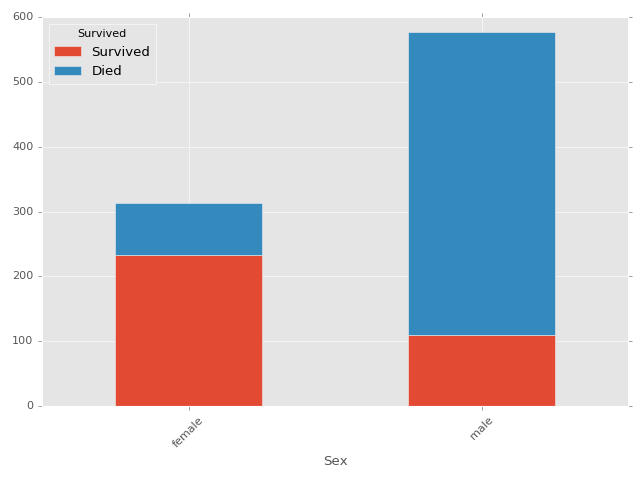

In [8]:
daw.show_one_chart()

# References


http://pandas.pydata.org/pandas-docs/stable/categorical.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html

http://pandas.pydata.org/pandas-docs/stable/groupby.html

http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html